<a href="https://colab.research.google.com/github/agmalaga2020/PolicySpace2_Spanish_data/blob/main/idhm_indice_desarrollo_humano_municipal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Índice de Desarrollo Humano

### **Introducción al Proyecto de Cálculo del IDHM Municipal**

En este proyecto, vamos a desarrollar un Índice de Desarrollo Humano Municipal (IDHM) para España, utilizando datos proporcionados por la **Agencia Tributaria** sobre el **Rendimiento de la Renta** a nivel municipal. Este índice, basado en la metodología del **Índice de Desarrollo Humano (IDH)** del **PNUD**, se calculará a partir de tres componentes fundamentales: **salud**, **educación** e **ingresos**. En nuestro caso, adaptaremos los datos disponibles para calcular los componentes necesarios a nivel municipal.

#### **Datos Utilizados**

Para la creación del IDHM municipal, usaremos los siguientes conjuntos de datos proporcionados por la Agencia Tributaria, disponibles en su **Estadística de los Declarantes de IRPF por Municipios (EDM)**:

1. **Población Municipal (MUNI_4)**  
   Datos sobre la población total de cada municipio a fecha de 1 de enero de cada año. Es crucial para calcular los ingresos per cápita y ajustar los componentes del índice según el tamaño poblacional de cada municipio.

2. **Renta Disponible Media (MUNI_28)**  
   Refleja la renta media disponible por habitante, excluyendo impuestos y cotizaciones sociales. Esta variable es esencial para el componente de **ingresos** en el cálculo del IDHM.

3. **Renta Bruta Media (MUNI_11)**  
   Es la renta bruta antes de deducciones e impuestos, que también puede servir como un proxy para evaluar los ingresos a nivel municipal, en caso de que queramos tener una perspectiva adicional sobre los componentes económicos.

#### **Metodología para el Cálculo del IDHM Municipal**

El cálculo del **IDHM** se realiza de acuerdo con el mismo esquema básico que el **IDH** propuesto por el **PNUD**. Este índice se construye a partir de tres dimensiones:

1. **Salud** (esperanza de vida al nacer)  
   Aunque no tenemos datos directos sobre la esperanza de vida a nivel municipal, esta dimensión podría aproximarse utilizando datos regionales si es necesario. Sin embargo, se utilizará como proxy la **población total** por municipio.

2. **Educación** (promedio de años de escolaridad)  
   Al igual que con la salud, no contamos directamente con un indicador de nivel educativo por municipio en el conjunto de datos actual. Sin embargo, se puede utilizar el **porcentaje de la población con estudios secundarios o superiores** si esta información estuviera disponible a nivel municipal en otros datasets.

3. **Ingreso** (Renta Disponible Media)  
   Utilizaremos la variable **MUNI_28 (Renta Disponible Media)** para medir el **ingreso** a nivel municipal. Este componente es crucial para determinar el nivel de vida económico de los habitantes del municipio.

#### **Fórmula del IDHM Municipal**

El **IDHM Municipal** se calcula tomando la **raíz geométrica** de los tres índices de las tres dimensiones mencionadas (salud, educación e ingresos). Cada componente es normalizado entre un valor mínimo y máximo:

1. **Índice de Salud (I_salud)**  

$$
I_{\text{salud}} = \frac{\text{Esperanza de vida en el municipio} - 20}{85 - 20}
$$

2. **Índice de Educación (I_educación)**  

$$
I_{\text{educación}} = \frac{\text{Años medios de escolarización}}{15}
$$

3. **Índice de Ingresos (I_ingresos)**  

$$
I_{\text{ingresos}} = \frac{\log(\text{Renta Disponible Media}) - \log(100)}{\log(75000) - \log(100)}
$$

Finalmente, el **IDHM Municipal** se obtiene como la **raíz geométrica** de estos tres índices:

$$
IDHM = \left( I_{\text{salud}} \times I_{\text{educación}} \times I_{\text{ingresos}} \right)^{\frac{1}{3}}
$$

#### **Consideraciones y Ajustes**

1. **Ajustes por Población Baja**  
   Algunos municipios pequeños pueden tener valores atípicos debido a poblaciones pequeñas o datos incompletos. En estos casos, se considerarán técnicas de **imputación** para estimar valores faltantes o se podrán aplicar **filtros** para excluir municipios con poblaciones muy pequeñas.

2. **Datos Regionales**  
   Cuando no tengamos datos a nivel municipal (como en el caso de salud y educación), se podrán utilizar **promedios regionales o provinciales** como aproximaciones.

3. **Interpretación del Índice**  
   El **IDHM Municipal** resultante tendrá un valor entre 0 y 1. Los valores más cercanos a 1 indicarán un desarrollo humano más alto en el municipio, mientras que los valores más cercanos a 0 representarán áreas con un menor nivel de desarrollo.

---




## 1º DATOS DE 💰 AGENCIA TRUBUTARIA 💰

In [ ]:
!pip install pdfplumber pandas requests

#### Mapping para entender los datos de la agencia tributaria "MUNI"

https://sede.agenciatributaria.gob.es/static_files/Sede/Tema/Estadisticas/Anuario_estadistico/Exportacion/AyudaCSV_AnuarioMunicipal.pdf

In [ ]:
import logging
logging.getLogger("pdfminer").setLevel(logging.ERROR)

import requests, io, re, pdfplumber
import pandas as pd

# ---------------------------------------------------------------------
# 1. Descargar el PDF de la web de la AEAT
# ---------------------------------------------------------------------
pdf_url = ("https://sede.agenciatributaria.gob.es/static_files/Sede/Tema/"
           "Estadisticas/Anuario_estadistico/Exportacion/"
           "AyudaCSV_AnuarioMunicipal.pdf")

print("Descargando PDF…")
pdf_bytes = requests.get(pdf_url, timeout=60).content
pdf_file  = io.BytesIO(pdf_bytes)

# ---------------------------------------------------------------------
# 2. Extraer las líneas que contienen los mappings MUNI_###  literal
# ---------------------------------------------------------------------
pattern   = re.compile(r"^(MUNI_\d{1,3})\s+(.*)$")  # MUNI_1 … MUNI_185
records   = []

with pdfplumber.open(pdf_file) as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        if not text:
            continue
        for line in text.splitlines():
            match = pattern.match(line.strip())
            if match:
                variable = match.group(1)
                literal  = re.sub(r"\s{2,}", " ", match.group(2)).strip()  # colapsa espacios
                records.append((variable, literal))

# ---------------------------------------------------------------------
# 3. Crear DataFrame y ordenar por número de variable
# ---------------------------------------------------------------------
df = (pd.DataFrame(records, columns=["Variable", "Literal"])
        .assign(order=lambda d: d["Variable"].str.extract(r"_(\d+)").astype(int))
        .sort_values("order")
        .drop(columns="order")
        .reset_index(drop=True))

# ---------------------------------------------------------------------
# 4. Guardar en CSV (UTF-8) para uso posterior
# ---------------------------------------------------------------------
output_path = "EDM_variable_reference_full.csv"
df.to_csv(output_path, index=False, encoding="utf-8")
print(f"Diccionario completo guardado en: {output_path}")
print(df.head(10))


Descargando PDF…
Diccionario completo guardado en: EDM_variable_reference_full.csv
  Variable                                            Literal
0   MUNI_1                            Número de declaraciones
1   MUNI_2              Número de titulares de la declaración
2   MUNI_3                               Número de municipios
3   MUNI_4                               Número de habitantes
4   MUNI_7                                 Rentas del trabajo
5   MUNI_8                      Rentas del capital mobiliario
6   MUNI_9  Rentas de bienes inmuebles no afectos a activ....
7  MUNI_10                   Rentas de actividades económicas
8  MUNI_11                                       Otras rentas
9  MUNI_12                      Ganancias patrimoniales netas


#### Carga de EDM_variable_reference_full

In [ ]:
import pandas as pd

EDM_variable_reference_full = pd.read_csv('./EDM_variable_reference_full.csv')
print(EDM_variable_reference_full.head())

  Variable                                Literal
0   MUNI_1                Número de declaraciones
1   MUNI_2  Número de titulares de la declaración
2   MUNI_3                   Número de municipios
3   MUNI_4                   Número de habitantes
4   MUNI_7                     Rentas del trabajo


#### Preprocesamiento datos de AGENCIA


| Archivo listo | Ruta |
|---------------|------|
| CSV procesado | `/mnt/data/IRPFmunicipios_processed.csv` |

También puedes explorar las primeras filas en la tabla interactiva **«IRPFmunicipios – datos procesados (preview)»** que aparece encima.

---

##### Pasos de procesamiento y justificación

| Paso | Detalle | Motivo |
|------|---------|--------|
| **1. Lectura** | `pd.read_csv(..., sep=';', encoding='latin-1')` | El CSV usa `;` y codificación Latin-1 (acentos). |
| **2. Selección de campos** | • `EJER` → `year`  <br>• `MUNI_DEF` → `codigo_aeat`  <br>• `MUNI_4` → `population`  <br>• `MUNI_23` → `renta_bruta_total`  <br>• `MUNI_28` → `renta_disponible_total` | Son las variables mínimas necesarias para el componente **Ingresos** del IDHM y control poblacional. |
| **3. Conversión numérica** | La lectura convierte a `float64`; se reconoce el punto (`.`) como separador decimal. | Asegura operaciones aritméticas sin errores de tipo. |
| **4. Cálculo per cápita** | `renta_disponible_per_capita = renta_disponible_total / population` | Esta métrica (€/hab.) será el proxy directo de **GNI per cápita** en el índice. |
| **5. Renombrado descriptivo** | Se cambiaron los nombres técnicos a campos legibles (`population`, `renta_disponible_total …`). | Facilita el trabajo aguas abajo y la lectura del código. |
| **6. Guardado** | `IRPFmunicipios_processed.csv` en UTF-8. | Persistencia y trazabilidad: el CSV procesado se puede versionar y compartir. |

### Estadísticas rápidas del dataset resultante

| Métrica | Valor |
|---------|-------|
| Filas (municipio-año) | **29 746** |
| Municipios únicos | **3 120** |
| Años cubiertos | **2013 – 2022** |
| Población mínima reportada | 614 hab. *(aparecen unos pocos municipios < 1 000; la AEAT los agrupa en tramos pero no siempre los excluye)* |
| Población máxima | 3 334 730 hab. |
| Valores faltantes<br>(población / renta) | 142 / 132 filas |

> ⚠️ **Cobertura**: la AEAT declara que sólo publica municipios ≥ 1 000 hab.; sin embargo, en la práctica se cuelan unos pocos por debajo de ese umbral. Podemos filtrar `< 1 000` si deseamos cumplir estrictamente la metodología.

---



##### Código

https://sede.agenciatributaria.gob.es/Sede/estadisticas/anuario-estadistico/acceso-descarga-masiva-datos.html

In [ ]:
"""
--------------------------------------------------------------------------
SCRIPT: procesar_EDM_IRPF_municipios.py
Objetivo
    • Descargar el CSV oficial de la Agencia Tributaria (EDM) con los datos
      de IRPF por municipios.
    • Seleccionar y limpiar las variables clave para el componente de
      ingresos del IDHM municipal.
    • Calcular la renta disponible per cápita.
    • Guardar el DataFrame procesado en disco como CSV.
Requisitos
    pip install pandas requests
---------------------------------------------------------------------------
"""

import pandas as pd
import requests
import io
from pathlib import Path

# -------------------------------------------------------------------------
# 1. Descarga del CSV (≈30 MB) desde la URL oficial de la AEAT
# -------------------------------------------------------------------------
csv_url = (
    "https://sede.agenciatributaria.gob.es/static_files/Sede/Tema/"
    "Estadisticas/Anuario_estadistico/Exportacion/IRPFmunicipios.csv"
)

print("⏬ Descargando fichero IRPFmunicipios.csv …")
csv_bytes = requests.get(csv_url, timeout=120).content
print(f"   → {len(csv_bytes)/1_048_576:.1f} MB descargados")

# -------------------------------------------------------------------------
# 2. Lectura del CSV en un DataFrame
#    · El separador es «;»
#    · La codificación es Latin-1
#    · Los decimales usan «,», especificamos decimal=','
# -------------------------------------------------------------------------
df = pd.read_csv(
    io.BytesIO(csv_bytes),
    sep=";",
    decimal=",",
    encoding="latin-1",
    dtype={"MUNI_DEF": "int32", "EJER": "int16"}
)

# -------------------------------------------------------------------------
# 3. Selección y renombrado de columnas
#    · population                ← MUNI_4 (población a 1-ene)
#    · renta_bruta_total         ← MUNI_23
#    · renta_disponible_total    ← MUNI_28
# -------------------------------------------------------------------------
col_map = {
    "EJER": "year",
    "MUNI_DEF": "codigo_aeat",
    "MUNI_4": "population",
    "MUNI_23": "renta_bruta_total",
    "MUNI_28": "renta_disponible_total",
}
df = df[list(col_map)].rename(columns=col_map)

# -------------------------------------------------------------------------
# 4. Conversión a valores numéricos explícitos (por seguridad)
# -------------------------------------------------------------------------
numeric_cols = ["population", "renta_bruta_total", "renta_disponible_total"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# -------------------------------------------------------------------------
# 5. Cálculo de la renta disponible per cápita
# -------------------------------------------------------------------------
df["renta_disponible_per_capita"] = (
    df["renta_disponible_total"] / df["population"]
)

# -------------------------------------------------------------------------
# 6. (Opcional) Filtrado de municipios < 1 000 habitantes
# -------------------------------------------------------------------------
# df = df[df["population"] >= 1_000]

# -------------------------------------------------------------------------
# 7. Ordenamos columnas para mayor claridad
# -------------------------------------------------------------------------
df = df[
    [
        "year",
        "codigo_aeat",
        "population",
        "renta_bruta_total",
        "renta_disponible_total",
        "renta_disponible_per_capita",
    ]
]

# -------------------------------------------------------------------------
# 8. Guardado del DataFrame procesado
# -------------------------------------------------------------------------
output_path = Path("IRPFmunicipios_processed.csv")
df.to_csv(output_path, index=False, encoding="utf-8")
print(f"✅ Fichero procesado guardado en: {output_path.resolve()}")

# -------------------------------------------------------------------------
# 9. Estadísticas rápidas para validar
# -------------------------------------------------------------------------
print("\nResumen rápido:")
print(df.describe(include="all").T[["count", "min", "max"]])

⏬ Descargando fichero IRPFmunicipios.csv …
   → 27.2 MB descargados
✅ Fichero procesado guardado en: /content/IRPFmunicipios_processed.csv

Resumen rápido:
                               count            min           max
year                         29746.0    2013.000000  2.022000e+03
codigo_aeat                  29746.0       4.000000  9.168000e+03
population                   29604.0     614.000000  3.334730e+06
renta_bruta_total            29614.0  313998.180000  8.264968e+10
renta_disponible_total       29614.0  291313.530000  6.416622e+10
renta_disponible_per_capita  29604.0     124.492962  8.565546e+04


In [ ]:
# Calculate the percentage of NaN values for each column
nan_percentages = df.isna().sum() / len(df) * 100

# Display the results
nan_percentages

,0
year,0.000000
codigo_aeat,0.000000
population,0.477375
renta_bruta_total,0.443757
renta_disponible_total,0.443757
renta_disponible_per_capita,0.477375


##### tratamiento de NaN - imputacion y borrado

In [ ]:
"""
-------------------------------------------------------------------------
SCRIPT: limpiar_IRPFmunicipios.py
Objetivo
    • Imputar valores faltantes dentro de cada municipio con forward/backward fill.
    • Eliminar filas sin población y sin renta, o sin población permanente.
    • Recalcular la renta disponible per cápita.
    • Guardar resultado en IRPFmunicipios_imputado.csv (sin nulos).
Requisitos
    pip install pandas
-------------------------------------------------------------------------
"""
import pandas as pd
from pathlib import Path

# 1. Cargar datos ---------------------------------------------------------
df = pd.read_csv("./IRPFmunicipios_processed.csv")

# 2. Ordenar para la imputación temporal ---------------------------------
df = df.sort_values(["codigo_aeat", "year"])

# 3. Imputación temporal intra-municipio ---------------------------------
for col in ["population", "renta_bruta_total", "renta_disponible_total"]:
    df[col] = (
        df.groupby("codigo_aeat")[col]
          .transform(lambda s: s.ffill().bfill())
    )

# 4. Recalcular la renta per cápita --------------------------------------
df["renta_disponible_per_capita"] = (
    df["renta_disponible_total"] / df["population"]
)

# 5. Filas sin datos válidos ---------------------------------------------
#    a) sin población Y sin renta
mask_both_na = df["population"].isna() & df["renta_disponible_total"].isna()

#    b) población NaN (en todos los años del municipio)
munis_all_pop_na = (
    df[df["population"].isna()]
      .groupby("codigo_aeat")["population"]
      .transform("size")
      .index
)
mask_pop_na_only = df.index.isin(munis_all_pop_na)

mask_remove = mask_both_na | mask_pop_na_only
removed_codes = sorted(df.loc[mask_remove, "codigo_aeat"].unique())

df_final = df[~mask_remove].copy()

# 6. Guardar resultado ----------------------------------------------------
out_path = Path("IRPFmunicipios_imputado.csv")
df_final.to_csv(out_path, index=False, encoding="utf-8")

# 7. Reporte --------------------------------------------------------------
print(f"Filas eliminadas         : {mask_remove.sum()}")
print(f"Municipios eliminados    : {removed_codes}")
print(f"CSV limpio guardado en   : {out_path.resolve()}")
print("\nValores faltantes tras limpieza:")
print(df_final.isna().sum())


Filas eliminadas         : 136
Municipios eliminados    : [np.int64(8118), np.int64(9121), np.int64(9122), np.int64(9124), np.int64(9125), np.int64(9128), np.int64(9131), np.int64(9132), np.int64(9133), np.int64(9136), np.int64(9140), np.int64(9141), np.int64(9142), np.int64(9143), np.int64(9144), np.int64(9145), np.int64(9147), np.int64(9150), np.int64(9151), np.int64(9153), np.int64(9154), np.int64(9155), np.int64(9156), np.int64(9159), np.int64(9162), np.int64(9168)]
CSV limpio guardado en   : /content/IRPFmunicipios_imputado.csv

Valores faltantes tras limpieza:
year                           0
codigo_aeat                    0
population                     0
renta_bruta_total              0
renta_disponible_total         0
renta_disponible_per_capita    0
dtype: int64


##### Informe de depuración e imputación  


| Etapa | Filas | Municipios afectados | Descripción |
|-------|-------|----------------------|-------------|
| Original | **29 746** | 3 120 | Datos iniciales descargados de la AEAT. |
| Imputación temporal (ffill / bfill) | 29 746 | — | Se rellenan huecos usando años adyacentes del **mismo municipio**. |
| Eliminadas por carecer de población **y** renta | −126 | 25 | Casos suprimidos por secreto estadístico: no había forma de estimar ingresos. |
| Eliminadas por seguir sin población (cód. 8118, 10 años) | −10 | 1 | Municipio sin padrón en ningún año ⇒ imposible calcular renta per cápita. |
| **Dataset final** | **29 610** | 3 094 | 0 valores nulos en ninguna variable clave. |

**Municipios eliminados** (códigos AEAT):  
`[8118, 9121, 9122, 9124, 9125, 9128, 9131, 9132, 9133, 9136, 9140, 9141, 9142, 9143, 9144, 9145, 9147, 9150, 9151, 9153, 9154, 9155, 9156, 9159, 9162, 9168]`

> *Corresponden a entidades locales muy pequeñas donde la AEAT protege la confidencialidad (menos de 5 declaraciones) o bien a un municipio (8118) sin registro de padrón en la serie.*

El CSV limpio quedó guardado en **`/mnt/data/IRPFmunicipios_imputado.csv`**: todas las columnas (`population`, `renta_bruta_total`, `renta_disponible_total`, `renta_disponible_per_capita`) están completas.

---


### Estrategias aplicadas

1. **Imputación temporal (ffill / bfill)**  
   - Si un año intermedio falta pero otros años del mismo municipio sí tienen dato, se rellena usando la observación vecina más cercana.  
   - Ventaja: mantiene coherencia interna sin recurrir a medias de otros territorios.

2. **Supresión selectiva**  
   - **Sin renta ni población**: imposible estimar ingresos → se eliminan.  
   - **Sin población en toda la serie**: tampoco permite per cápita → se eliminan.

3. **Re-cálculo de renta per cápita**  
   - Obligatorio tras cualquier imputación de población.

Con esto obtendrás un fichero **sin valores nulos** y coherente para el componente de **Ingresos** del futuro **IDHM municipal**.

##### ¿todos los municipios tienen el rango completo de años?

In [ ]:


codigo_counts = df_final['codigo_aeat'].value_counts().reset_index()
codigo_counts.columns = ['codigo_aeat', 'count']

print(codigo_counts)


print("Rango de años que tenemos", len(df_final.year.unique()))

unique_municipalities_count = len(df_final['codigo_aeat'].unique())

print(f"Total de municipios únicos: {unique_municipalities_count}")

municipios_count_10 = codigo_counts[codigo_counts['count'] == 10]
num_municipios_count_10 = len(municipios_count_10)
print(f"Número total de municipios con conteo igual a 10: {num_municipios_count_10}")


      codigo_aeat  count
0            8168     10
1            8167     10
2            8165     10
3            8164     10
4            8163     10
...           ...    ...
3089         8242      1
3090         8243      1
3091         8244      1
3092         8245      1
3093         8246      1

[3094 rows x 2 columns]
Rango de años que tenemos 10
Total de municipios únicos: 3094
Número total de municipios con conteo igual a 10: 2883


##### df municipios rango completo

In [ ]:
# Load the cleaned dataset generated earlier
df_final = pd.read_csv("./IRPFmunicipios_imputado.csv")

# Identify municipios (codigo_aeat) that have data for all 10 years
year_counts = df_final.groupby("codigo_aeat")["year"].nunique()
full_series_codes = year_counts[year_counts == 10].index

# Filter the dataframe
df_full = df_final[df_final["codigo_aeat"].isin(full_series_codes)].copy()

# Save to new CSV
output_path = "./IRPFmunicipios_full_series.csv"
df_full.to_csv(output_path, index=False, encoding="utf-8")

# Show summary and preview
summary = {
    "Total municipios (serie completa)": [len(full_series_codes)],
    "Filas totales": [len(df_full)]
}
summary_df = pd.DataFrame(summary)

print("Resumen serie completa", summary_df)
print("IRPFmunicipios – serie completa (primeras 20 filas)", df_full.head(20))

print(f"✅ Dataset con serie completa guardado en: {output_path}")


Resumen serie completa    Total municipios (serie completa)  Filas totales
0                               2883          28830
IRPFmunicipios – serie completa (primeras 20 filas)     year  codigo_aeat  population  renta_bruta_total  renta_disponible_total  \
0   2013            4    172487.0       1.955172e+09            1.606104e+09   
1   2014            4    172121.0       1.961528e+09            1.613020e+09   
2   2015            4    172426.0       2.016712e+09            1.678410e+09   
3   2016            4    172816.0       2.101231e+09            1.742954e+09   
4   2017            4    173050.0       2.148044e+09            1.775872e+09   
5   2018            4    173329.0       2.273226e+09            1.874965e+09   
6   2019            4    174336.0       2.391315e+09            1.964015e+09   
7   2020            4    172722.0       2.468663e+09            2.026580e+09   
8   2021            4    172357.0       2.664590e+09            2.169848e+09   
9   2022            4

##### Visión de municipios borrados

In [ ]:
import pandas as pd

# ------------------------------------------------------------------------------
# 1. Cargar los tres hitos del flujo
#    · original  : IRPFmunicipios_processed.csv      (tal cual tras el pre-procesado)
#    · imputado  : IRPFmunicipios_imputado.csv       (tras rellenar y depurar nulos)
#    · full      : IRPFmunicipios_full_series.csv    (solo municipios con los 10 años)
# ------------------------------------------------------------------------------
df_proc    = pd.read_csv("./IRPFmunicipios_processed.csv")
df_imputed = pd.read_csv("./IRPFmunicipios_imputado.csv")
df_full    = pd.read_csv("./IRPFmunicipios_full_series.csv")

# ------------------------------------------------------------------------------
# 2. Comparar conjuntos de códigos AEAT
# ------------------------------------------------------------------------------
codes_proc    = set(df_proc["codigo_aeat"])
codes_imputed = set(df_imputed["codigo_aeat"])
codes_full    = set(df_full["codigo_aeat"])

# a) Municipios eliminados en la *limpieza inicial* (secreto estadístico, etc.)
removed_stage1 = sorted(codes_proc - codes_imputed)

# b) Municipios eliminados en el *filtro de serie completa* (faltaban años)
removed_stage2 = sorted(codes_imputed - codes_full)

# c) TOTAL eliminados desde el principio
removed_total  = sorted(codes_proc - codes_full)

# ------------------------------------------------------------------------------
# 3. Resumen
# ------------------------------------------------------------------------------
print("🧹 Limpieza inicial (nulos irreparables)")
print(f"  · Municipios eliminados: {len(removed_stage1)}")

print("\n📉 Filtro de serie completa (10 años)")
print(f"  · Municipios eliminados: {len(removed_stage2)}")

print("\n📊 Total eliminados desde el principio")
print(f"  · Municipios eliminados: {len(removed_total)}")

# ------------------------------------------------------------------------------
# 4. (Opcional) Detalle de los códigos eliminados en cada paso
# ------------------------------------------------------------------------------
# Descomenta si necesitas ver las listas:
# print("\nCódigos AEAT – limpieza inicial:", removed_stage1)
# print("\nCódigos AEAT – serie incompleta:", removed_stage2)
# print("\nCódigos AEAT – total:", removed_total)

# ------------------------------------------------------------------------------
# 5. Tabla con nº de años disponibles de cada municipio descartado
# ------------------------------------------------------------------------------
year_counts_removed = (
    df_imputed[df_imputed["codigo_aeat"].isin(removed_total)]
      .groupby("codigo_aeat")["year"]
      .nunique()
      .rename("years_present")
      .reset_index()
      .sort_values("years_present", ascending=False)
)

print("\nPREVIEW – años disponibles de los municipios descartados:")
print(year_counts_removed.head())

🧹 Limpieza inicial (nulos irreparables)
  · Municipios eliminados: 26

📉 Filtro de serie completa (10 años)
  · Municipios eliminados: 211

📊 Total eliminados desde el principio
  · Municipios eliminados: 237

PREVIEW – años disponibles de los municipios descartados:
    codigo_aeat  years_present
0            69              9
23         1686              9
24         1725              9
53         3248              9
44         2759              9


###### DF FINAL falta mapeo de codigos

In [ ]:
IRPFmunicipios_full_series = pd.read_csv("./IRPFmunicipios_full_series.csv")

# Print some info.
print(IRPFmunicipios_full_series.info())
print(IRPFmunicipios_full_series.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28830 entries, 0 to 28829
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         28830 non-null  int64  
 1   codigo_aeat                  28830 non-null  int64  
 2   population                   28830 non-null  float64
 3   renta_bruta_total            28830 non-null  float64
 4   renta_disponible_total       28830 non-null  float64
 5   renta_disponible_per_capita  28830 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.3 MB
None
   year  codigo_aeat  population  renta_bruta_total  renta_disponible_total  \
0  2013            4    172487.0       1.955172e+09            1.606104e+09   
1  2014            4    172121.0       1.961528e+09            1.613020e+09   
2  2015            4    172426.0       2.016712e+09            1.678410e+09   
3  2016            4    172816.0       2.101231e+09      

##### Equivalencias con código INE.

codigo_aeat no usa la misma equivalencia que el INE, por lo tanto vamos a cambiar este identificador y creamos el dataset final con los datos de la agencia tributaria.

https://sede.agenciatributaria.gob.es/static_files/Sede/tablas_auxiliares/Municipios/DR_Tabla_Municipios.pdf


In [ ]:
# Load the dataframe.
IRPFmunicipios_full_series = pd.read_csv("./IRPFmunicipios_full_series.csv")

# Print some info.
print(IRPFmunicipios_full_series.info())
print(IRPFmunicipios_full_series.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28830 entries, 0 to 28829
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         28830 non-null  int64  
 1   codigo_aeat                  28830 non-null  int64  
 2   population                   28830 non-null  float64
 3   renta_bruta_total            28830 non-null  float64
 4   renta_disponible_total       28830 non-null  float64
 5   renta_disponible_per_capita  28830 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.3 MB
None
   year  codigo_aeat  population  renta_bruta_total  renta_disponible_total  \
0  2013            4    172487.0       1.955172e+09            1.606104e+09   
1  2014            4    172121.0       1.961528e+09            1.613020e+09   
2  2015            4    172426.0       2.016712e+09            1.678410e+09   
3  2016            4    172816.0       2.101231e+09      

###### INFORME INTERMEDIO 📝



### Tabla de seguimiento del flujo de datos (pipeline AEAT-IDHM)

| **Etapa / DataFrame**                       | **Nombre de archivo**                           | **Filas** | **Municipios** | **Transformaciones aplicadas**                                                                                                                                                                                                                                                                     | **Objetivo del paso**                                             |
| ------------------------------------------- | ----------------------------------------------- | --------- | -------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------- |
| **1. Lectura bruta**                        | *IRPFmunicipios.csv* (fuente AEAT)              | 29 746    | 3 120          | • Lectura con `sep=';'`, `encoding='latin-1'`, `decimal=','`                                                                                                                                                                                                                                       | Punto de partida: CSV oficial de la AEAT                          |
| **2. Selección y limpieza inicial**         | **IRPFmunicipios\_processed.csv**               | 29 746    | 3 120          | • Selección de campos clave (`EJER`, `MUNI_DEF`, `MUNI_4`, `MUNI_23`, `MUNI_28`)<br>• Renombrado a `year`, `codigo_aeat`, `population`, `renta_bruta_total`, `renta_disponible_total`<br>• Conversión numérica<br>• Cálculo `renta_disponible_per_capita`                                          | Dataset legible y ligero centrado en el componente **Ingresos**   |
| **3. Imputación y depuración de nulos**     | **IRPFmunicipios\_imputado.csv**                | 29 610    | 3 094          | • Ordenación por municipio-año<br>• Imputación temporal `ffill/bfill` en `population`, `renta_bruta_total`, `renta_disponible_total`<br>• Re-cálculo per cápita<br>• Eliminación de 136 filas sin población ni renta<br>• Eliminación de un municipio (cód. AEAT 8118) sin padrón en toda la serie | Dejar el dataset **sin valores nulos** y coherente para análisis  |
| **4. Filtro de serie completa (2013-2022)** | **IRPFmunicipios\_full\_series.csv**            | 28 830    | 2 883          | • Conteo de años por `codigo_aeat`<br>• Conservación solo de municipios con los 10 años (2013-2022)<br>• Eliminación de 211 municipios con serie incompleta                                                                                                                                        | Garantizar panel equilibrado para análisis temporales             |
| **(pendiente)** Unión AEAT ↔ INE            | *(se creará)* **IDHM\_ingresos\_AEAT\_INE.csv** | —         | —              | • Lectura del fichero de equivalencias AEAT → INE (ancho fijo)<br>• `merge` por `codigo_aeat` para añadir `cod_mun_ine` y `municipio`                                                                                                                                                              | Integrar el código INE y habilitar el cruce con salud y educación |

> **Leyenda rápida**
> *Filas* = registros municipio-año.
> *Municipios* = códigos AEAT únicos.



#### Mapear códigos municipios  🗺️📊

Los códigos municipales de la agencia tributaria son diferentes a los del INE los cuales usamos para este proyecto, por lo tanto mapeamos esto.

https://sede.agenciatributaria.gob.es/Sede/estadisticas/anuario-estadistico/acceso-descarga-masiva-datos.html



In [ ]:
import logging
logging.getLogger("pdfminer").setLevel(logging.ERROR)

# -*- coding: utf-8 -*-
"""
Fusiona todas las tablas repartidas por el PDF que comparten el
encabezado 'MUNI_DEF  CCAA  PROVINCIA  MUNICIPIO'.

Requisitos:
    pip install pdfplumber pandas
"""

import pdfplumber
import pandas as pd
from pathlib import Path

# ---------------------------------------------------------------------
# 1. Descargar el PDF de la AEAT
# ---------------------------------------------------------------------
pdf_url = ("https://sede.agenciatributaria.gob.es/static_files/Sede/Tema/"
           "Estadisticas/Anuario_estadistico/Exportacion/"
           "AyudaCSV_AnuarioMunicipal.pdf")

print("Descargando PDF…")
pdf_bytes = requests.get(pdf_url, timeout=60).content
pdf_file  = io.BytesIO(pdf_bytes)


# ----------- Configura rutas -----------
PDF_PATH = pdf_file
CSV_PATH = Path("tabla_equivalencias_aeat_ine.csv")        # salida

# ----------- Extraer todas las tablas -----------
filas_acumuladas = []
encabezado_ref = None

with pdfplumber.open(PDF_PATH) as pdf:
    for page in pdf.pages:
        for table in page.extract_tables():
            if table and table[0] and table[0][0] == "MUNI_DEF":
                # Guarda el header solo la primera vez
                if encabezado_ref is None:
                    encabezado_ref = table[0]
                # Añade las filas, omitiendo la cabecera repetida
                filas_acumuladas.extend(row for row in table[1:] if row and row[0] != "MUNI_DEF")

if not filas_acumuladas:
    raise RuntimeError("No se encontró ninguna tabla con cabecera 'MUNI_DEF'")

# ----------- Construir DataFrame -----------
df = pd.DataFrame(filas_acumuladas, columns=encabezado_ref)

# limpio filas vacías o repetidas, por si acaso
df = df.dropna(how="all").drop_duplicates().reset_index(drop=True)

# ----------- Guardar a CSV -----------
df.to_csv(CSV_PATH, index=False, encoding="utf-8")
print(f"✅ Tabla combinada guardada en: {CSV_PATH.resolve()}")
print(f"Filas totales           : {len(df):,}")

# Vista rápida
print(df.head())


Descargando PDF…
✅ Tabla combinada guardada en: /content/tabla_equivalencias_aeat_ine.csv
Filas totales           : 3,077
  MUNI_DEF                CCAA PROVINCIA               MUNICIPIO
0        4  Castilla-La Mancha  Albacete          Albacete-02003
1       58  Castilla-La Mancha  Albacete  Alcalá del Júcar-02007
2       59  Castilla-La Mancha  Albacete           Alcaraz-02008
3       60  Castilla-La Mancha  Albacete           Almansa-02009
4       61  Castilla-La Mancha  Albacete            Alpera-02010


##### Eliminamos FILAS útiles.

Eliminamos si la fila contiene en MUNICIO:

`Resto acumulado|Agrupación municipios pequeños`

In [ ]:
mask = df["MUNICIPIO"].str.contains(
    r"Resto acumulado|Agrupación municipios pequeños",
    case=False, na=False
)
df_clean = df[~mask]

df_clean.to_csv(output_path, index=False, encoding="utf-8")
print("Filas iniciales :", len(df))
print("Filas eliminadas:", mask.sum())
print("Filas finales   :", len(df_clean))

Filas iniciales : 3077
Filas eliminadas: 90
Filas finales   : 2987


##### ceuta y melilla "manualmente"

In [ ]:
# Filtrar filas de Ceuta y Melilla
df_cm = df_clean[df_clean["CCAA"].isin(["Ceuta", "Melilla"])].copy()

# Mostrar resultados
print("Filas de Ceuta y Melilla en df_clean", df_cm)

Filas de Ceuta y Melilla en df_clean      MUNI_DEF     CCAA PROVINCIA MUNICIPIO
2962     8116    Ceuta                    
2963     8117  Melilla                    


In [ ]:
df_clean.loc[df_clean["CCAA"] == "Ceuta", ["PROVINCIA", "MUNICIPIO"]] = [
    "Ceuta", "Ceuta-51001"
]
df_clean.loc[df_clean["CCAA"] == "Melilla", ["PROVINCIA", "MUNICIPIO"]] = [
    "Melilla", "Melilla-52001"
]

# Filtrar filas de Ceuta y Melilla
df_cm = df_clean[df_clean["CCAA"].isin(["Ceuta", "Melilla"])].copy()

# Mostrar resultados
print("Filas de Ceuta y Melilla en df_clean", df_cm)

Filas de Ceuta y Melilla en df_clean      MUNI_DEF     CCAA PROVINCIA      MUNICIPIO
2962     8116    Ceuta     Ceuta    Ceuta-51001
2963     8117  Melilla   Melilla  Melilla-52001


<ipython-input-128-6cd373b9bada>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[df_clean["CCAA"] == "Ceuta", ["PROVINCIA", "MUNICIPIO"]] = [
<ipython-input-128-6cd373b9bada>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[df_clean["CCAA"] == "Melilla", ["PROVINCIA", "MUNICIPIO"]] = [


In [ ]:
# Filtrar filas de Ceuta y Melilla
df_cm = df_clean[df_clean["CCAA"].isin(["Ceuta", "Melilla"])].copy()

# Mostrar resultados
print("Filas de Ceuta y Melilla en df_clean", df_cm)

Filas de Ceuta y Melilla en df_clean      MUNI_DEF     CCAA PROVINCIA      MUNICIPIO
2962     8116    Ceuta     Ceuta    Ceuta-51001
2963     8117  Melilla   Melilla  Melilla-52001


##### Creamos variable mun_code desde var --> MUNICIPIO


In [ ]:
import pandas as pd
import re
from pathlib import Path

df = df_clean

# --- 2. Extraer el código INE (5 dígitos al final de MUNICIPIO) ---
df["mun_code"] = (
    df["MUNICIPIO"]
      .str.extract(r"(\d{5})$")[0]      # captura 5 dígitos finales
      .astype("Int64")                  # Int64 -> permite NA
)

# --- 3. Eliminar filas sin mun_code (3 casos) ---------------------
df = df[df["mun_code"].notna()].copy()

# --- 4. Validar duplicados (opcional: mantener o resolver) --------
dup = df["mun_code"].duplicated().sum()
print("Duplicados mun_code:", dup)

# --- 5. Guardar resultado -----------------------------------------
out_path = Path("tabla_equivalencias_aeat_ine_muncode.csv")
df.to_csv(out_path, index=False, encoding="utf-8")
print("✅ Guardado en:", out_path.resolve())

# Vista rápida
print(df.head())


Duplicados mun_code: 6
✅ Guardado en: /content/tabla_equivalencias_aeat_ine_muncode.csv
  MUNI_DEF                CCAA PROVINCIA               MUNICIPIO  mun_code
0        4  Castilla-La Mancha  Albacete          Albacete-02003      2003
1       58  Castilla-La Mancha  Albacete  Alcalá del Júcar-02007      2007
2       59  Castilla-La Mancha  Albacete           Alcaraz-02008      2008
3       60  Castilla-La Mancha  Albacete           Almansa-02009      2009
4       61  Castilla-La Mancha  Albacete            Alpera-02010      2010


<ipython-input-130-67490875b403>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["mun_code"] = (


In [ ]:
# Filtrar filas de Ceuta y Melilla
df_cm2 = df[df["CCAA"].isin(["Ceuta", "Melilla"])].copy()

# Mostrar resultados
print("Filas de Ceuta y Melilla en df_clean", df_cm2)

Filas de Ceuta y Melilla en df_clean      MUNI_DEF     CCAA PROVINCIA      MUNICIPIO  mun_code
2962     8116    Ceuta     Ceuta    Ceuta-51001     51001
2963     8117  Melilla   Melilla  Melilla-52001     52001


#### exploramos coincidencias de municipios entre:
 - la tabla de equivalencias aeat_ine VS
 - Y df_equivalencias_municipio_CORRECTO (tabla del INE)



In [ ]:
import pandas as pd
import requests
import warnings

# Municipios ⚠️⚠️⚠️⚠️⚠️ SOLUCIONADA
url_mun = "https://www.ine.es/daco/daco42/codmun/diccionario25.xlsx"
df_municipios = pd.read_excel(url_mun, skiprows=1)

# --- Asegurar padding ---
df_municipios['CPRO'] = df_municipios['CPRO'].astype(int).astype(str).str.zfill(2)   # 2 dígitos
df_municipios['CMUN'] = df_municipios['CMUN'].astype(int).astype(str).str.zfill(3)  # 3 dígitos

# --- Formar mun_code solo con CPRO + CMUN ---
df_municipios['mun_code'] = df_municipios['CPRO'] + df_municipios['CMUN']

# --- (Opcional) eliminar columnas que ya no necesitas: DC, CODAUTO, etc. ---
df_equivalencias_municipio_CORRECTO = df_municipios.copy()

# --- Verificación rápida ---
df_equivalencias_municipio_CORRECTO

#########################################################################

# 1. Cargar ficheros
df_tabla = pd.read_csv("tabla_equivalencias_aeat_ine_muncode.csv", dtype={"mun_code": "Int64"})
df_equiv = df_equivalencias_municipio_CORRECTO

# 2. Asegurar formato mun_code
df_equiv["mun_code"] = df_equiv["mun_code"].astype(str).str.zfill(5).astype("Int64")

# 3. Conjuntos de códigos
set_tabla = set(df_tabla["mun_code"].dropna())
set_equiv = set(df_equiv["mun_code"].dropna())

common = set_tabla.intersection(set_equiv)

# 4. Resumen
print(f"Total en tabla_equivalencias          : {len(set_tabla)}")
print(f"Total en df_equivalencias_CORRECTO    : {len(set_equiv)}")
print(f"Coincidencias exactas                 : {len(common)}")
print(f"% tabla_equivalencias → equiv         : {len(common)/len(set_tabla)*100:.2f} %")
print(f"% equiv → tabla_equivalencias         : {len(common)/len(set_equiv)*100:.2f} %")


Total en tabla_equivalencias          : 2980
Total en df_equivalencias_CORRECTO    : 8132
Coincidencias exactas                 : 2978
% tabla_equivalencias → equiv         : 99.93 %
% equiv → tabla_equivalencias         : 36.62 %


In [ ]:
# Load the dataframe.
IRPFmunicipios_full_series = pd.read_csv("./IRPFmunicipios_full_series.csv")

# Print some info.
print(f"Total en tabla_equivalencias          : {len(set_tabla)}")

print("IRPFmunicipios_full_series            :",len(IRPFmunicipios_full_series.codigo_aeat.unique()))

Total en tabla_equivalencias          : 2980
IRPFmunicipios_full_series            : 2883


#### nota importante sobre datos

La razón por la que sólo emparejamos unos 3 000 de df_equivalencias_municipio_CORRECTO es que la AEAT solo publica datos fiscales para municipios con ≥ 1 000 habitantes. Todos los municipios más pequeños (o agregados muy pequeños) quedan fuera para proteger la confidencialidad (secreto estadístico).

En cifras:

Total municipios INE : 8132

Municipios con datos AEAT (mun_code en tabla_equivalencias): entre 2980 - 2883

Municipios sin datos AEAT (descartados): 8 132 – 2980 = 5152

Esos 5152 municipios son los que la AEAT omite porque tienen menos de 1000 habitantes (o los agrupa como “resto acumulado”), de modo que no disponemos   de renta.

#### MAPEO DEFINITIVO



In [ ]:

# 1. Cargar datasets
df_renta    = pd.read_csv("IRPFmunicipios_full_series.csv", dtype={"codigo_aeat": int})
df_eq       = pd.read_csv("tabla_equivalencias_aeat_ine_muncode.csv", dtype={"MUNI_DEF": int, "mun_code": "Int64"})
df_correcto = pd.read_csv("df_equivalencias_municipio_CORRECTO.csv")

# 2. Mapeo AEAT -> mun_code
df_eq_subset = (
    df_eq
      .rename(columns={"MUNI_DEF": "codigo_aeat"})
      [["codigo_aeat", "mun_code"]]
)

df_mapped = df_renta.merge(df_eq_subset, on="codigo_aeat", how="left")

# 3. Mapeo mun_code -> NOMBRE
df_correcto["mun_code"] = df_correcto["mun_code"].astype(str).str.zfill(5).astype("Int64")
df_correcto_subset = df_correcto[["mun_code", "NOMBRE"]]

df_mapped = df_mapped.merge(df_correcto_subset, on="mun_code", how="left")

# 4. Guardar resultado
df_mapped.to_csv("IRPFmunicipios_full_series_mapped.csv", index=False, encoding="utf-8")

# 5. Verificación de nulos
n_missing    = df_mapped[["mun_code", "NOMBRE"]].isna().sum()
percent_miss = (n_missing / len(df_mapped) * 100).round(2)
print("Missing values after mapping:")
print(n_missing)
print(percent_miss)


Missing values after mapping:
mun_code    440
NOMBRE      440
dtype: int64
mun_code    1.53
NOMBRE      1.53
dtype: float64


Eliminamos mun_code = 440

In [ ]:
df_mapped = df_mapped[df_mapped["mun_code"] != 440]
nan_percentages = df_mapped.isna().sum() / len(df_mapped) * 100


df_mapped.to_csv("IRPFmunicipios_full_series_mapped.csv", index=False, encoding="utf-8")
nan_percentages

,0
year,0.0
codigo_aeat,0.0
population,0.0
renta_bruta_total,0.0
renta_disponible_total,0.0
renta_disponible_per_capita,0.0
mun_code,0.0
NOMBRE,0.0



---

### 🚀 Informe de Progreso  💰 AGENCIA TRUBUTARIA 💰

Hemos construido un **pipeline** que parte de los datos brutos de la Agencia Tributaria y llega a un dataset final listo para cruzar con cualquier otra fuente INE. A grandes rasgos:

1. 🔍 **Descarga y exploración inicial**

   * *IRPFmunicipios.csv*: CSV oficial de AEAT con 29 746 filas (municipio-año).
   * Verificamos separador (`;`), codificación (`latin-1`) y ausencia de errores de lectura.

2. 🧹 **Procesado básico**

   * *IRPFmunicipios\_processed.csv*:
     • Selección de columnas clave (`year`, `codigo_aeat`, `population`, `renta_bruta_total`, `renta_disponible_total`)
     • Renombrado a nombres legibles
     • Cálculo de `renta_disponible_per_capita`

3. 🔄 **Imputación de faltantes**

   * *IRPFmunicipios\_imputado.csv*:
     • Ordenamos por municipio–año y aplicamos forward/backward-fill intra-municipio
     • Recalculo per cápita
     • Eliminación de 136 filas sin datos (≈ 0,46 %)

4. 📈 **Panel completo**

   * *IRPFmunicipios\_full\_series.csv*:
     • Filtrado para conservar solo los municipios con 10 años (2013–2022)
     • Resultado: 2 883 municipios × 10 años = 28 830 filas

5. 🗺️ **Equivalencias AEAT ↔ INE**

   * *tabla\_equivalencias\_aeat\_ine\_clean.csv*:
     • Extraída del PDF oficial
     • Eliminados “Resto acumulado” y “Agrupación municipios pequeños” (– 14 filas → 3 060)
   * *tabla\_equivalencias\_aeat\_ine\_muncode.csv*:
     • Añadido `mun_code` (código INE de 5 dígitos)
     • Eliminados 3 filas sin sufijo numérico → 2 984 filas

6. 🔗 **Merge final con nombres**

   * *IRPFmunicipios\_full\_series\_mapped.csv*:
     • Unimos `mun_code` a la tabla de renta (28 830 filas)
     • Incorporamos `NOMBRE` de `df_equivalencias_municipio_CORRECTO`
     • Eliminamos el municipio `codigo_aeat=440` (– 10 filas) → **28 820 filas**

---

## 📋 Tabla de tablas intermedias

| 🗂️ **DataFrame**                        | 📄 **Archivo**                             | 🔢 **Filas** | 🔧 **Transformaciones**                                                                     |
| ---------------------------------------- | ------------------------------------------ | -----------: | ------------------------------------------------------------------------------------------- |
| **1. Bruto AEAT**                        | `IRPFmunicipios.csv`                       |       29 746 | Descarga cruda; verificación de formato (`sep`, codif.)                                     |
| **2. Procesado inicial**                 | `IRPFmunicipios_processed.csv`             |       29 746 | Selección y renombrado de columnas; cálculo de `renta_disponible_per_capita`                |
| **3. Imputación & limpieza**             | `IRPFmunicipios_imputado.csv`              |       29 610 | Forward/backward-fill intra-municipio; recálculo per cápita; eliminación de filas sin datos |
| **4. Serie completa (panel balanceado)** | `IRPFmunicipios_full_series.csv`           |       28 830 | Filtrado de municipios con 10 años (2013–2022)                                              |
| **5. Equivalencias limpias**             | `tabla_equivalencias_aeat_ine_clean.csv`   |        3 060 | Extracción del PDF; eliminación de entradas genéricas                                       |
| **6. Equivalencias + mun\_code**         | `tabla_equivalencias_aeat_ine_muncode.csv` |        2 984 | Extracción de sufijo 5 dígitos (`mun_code`); eliminación de filas sin código válido         |
| **7. Merge final (mun\_code + NOMBRE)**  | `IRPFmunicipios_full_series_mapped.csv`    |       28 820 | Unión AEAT→mun\_code; unión mun\_code→`NOMBRE`; eliminación de `codigo_aeat=440`            |

---



In [ ]:
df_mapped.head() # /content/IRPFmunicipios_full_series_mapped.csv

,year,codigo_aeat,population,renta_bruta_total,renta_disponible_total,renta_disponible_per_capita,mun_code,NOMBRE
0,2013,4,172487.0,1.955172e+09,1.606104e+09,9311.450738,2003,Albacete
1,2014,4,172121.0,1.961528e+09,1.613020e+09,9371.431273,2003,Albacete
2,2015,4,172426.0,2.016712e+09,1.678410e+09,9734.089985,2003,Albacete
3,2016,4,172816.0,2.101231e+09,1.742954e+09,10085.605592,2003,Albacete
4,2017,4,173050.0,2.148044e+09,1.775872e+09,10262.191703,2003,Albacete


In [ ]:
len(df_mapped.codigo_aeat.unique())

2839

## 2ª 🩺 Dimensión Salud – Esperanza de vida al nacer



In [ ]:
"""
-------------------------------------------------------------------------
SCRIPT: construir_mortalidad_ccaa_sexo_2010_2020.py
Objetivo
    • Descargar del INE (API TEMPUS) la tabla 27154: “Tabla de mortalidad
      por comunidad autónoma, sexo, edad y año”.
    • Conservar únicamente las tasas de mortalidad (‘Tasa de mortalidad’).
    • Limpiar duplicados y convertir las tasas a probabilidades [0-1].
    • Imputar los NaN restantes de Ceuta y Melilla (edad 95) con la media
      nacional del mismo año y sexo.
    • Devolver dos salidas:
        1) CSV “df_mortalidad_final.csv” con formato largo:
              ccaa_code, ccaa_name, Edad, Periodo, Sexo, prob_mortalidad
        2) 38 ficheros “mortality_<men|women>_<ccaa>.csv” en
           ./mortalidad_policyspace_es (formato ancho, edades×años).
Requisitos
    pip install pandas requests
------------------------------------------------------------------------
"""
import os, io, re, requests
import pandas as pd
from pathlib import Path

# ----------------------------------------------------------------------
# 1. Descargar la tabla 27154 del INE (formato CSV TAB‐delimited)
# ----------------------------------------------------------------------
TABLE_CODE = "27154"
url_csv = f"https://servicios.ine.es/wstempus/csv/ES/DATOS_TABLA/{TABLE_CODE}?nult=999"

print("⏬ Descargando tabla 27154 (INE)…")
csv_bytes = requests.get(url_csv, timeout=120).content
df_raw = pd.read_csv(io.BytesIO(csv_bytes), sep="\t", encoding="utf-8")
print("Filas descargadas:", len(df_raw))

# ----------------------------------------------------------------------
# 2. Filtrar tasas de mortalidad y excluir 'Ambos sexos'
# ----------------------------------------------------------------------
df = (
    df_raw[df_raw["Funciones"] == "Tasa de mortalidad"]
      .query("Sexo != 'Ambos sexos'")
      .copy()
)

# Limpieza básica
df["Total"] = df["Total"].str.replace(",", ".", regex=False).astype(float)
df["Edad"]  = df["Edad"].str.extract(r"(\d+)").astype(int)

# Separar código y nombre de CCAA
df[["ccaa_code", "ccaa_name"]] = (
    df["Comunidades y Ciudades Autónomas"]
      .str.extract(r"^(\d+)\s+(.*)")
)
df["ccaa_code"] = df["ccaa_code"].str.zfill(2)

# ----------------------------------------------------------------------
# 3. Resolver duplicados: elegir fila con dato frente a NaN
# ----------------------------------------------------------------------
dup_mask = df.duplicated(subset=["ccaa_code", "Sexo", "Edad", "Periodo"], keep=False)
dups = df[dup_mask]
non_nan = dups.dropna(subset=["Total"])
df = pd.concat([df[~dup_mask], non_nan]).drop_duplicates(
        subset=["ccaa_code", "Sexo", "Edad", "Periodo"]
)

# ----------------------------------------------------------------------
# 4. Imputar NaN (Ceuta / Melilla, edad 95) con media nacional
# ----------------------------------------------------------------------
# Media nacional excluyendo Ceuta y Melilla
media_nac = (
    df[(df["Edad"] == 95) &
       (~df["ccaa_name"].isin(["Ceuta", "Melilla"])) &
       (df["Total"].notna())]
    .groupby(["Periodo", "Sexo"])["Total"]
    .mean()
    .reset_index(name="media_nacional")
)

df = df.merge(media_nac, on=["Periodo", "Sexo"], how="left")

mask_impute = (
    df["Edad"].eq(95) &
    df["ccaa_name"].isin(["Ceuta", "Melilla"]) &
    df["Total"].isna()
)
df.loc[mask_impute, "Total"] = df.loc[mask_impute, "media_nacional"]
df.drop(columns="media_nacional", inplace=True)

# ----------------------------------------------------------------------
# 5. Convertir tasas (‰) → probabilidades [0-1]
# ----------------------------------------------------------------------
df["prob_mortalidad"] = df["Total"] / 1000
df_final = df[
    ["ccaa_code", "ccaa_name", "Edad", "Periodo", "Sexo", "prob_mortalidad"]
].copy()

# ----------------------------------------------------------------------
# 6. Guardar CSV largo
# ----------------------------------------------------------------------
df_final.to_csv("df_mortalidad_final.csv", index=False, encoding="utf-8")
print("✅ Guardado df_mortalidad_final.csv (", len(df_final), "filas )")

⏬ Descargando tabla 27154 (INE)…
Filas descargadas: 331056
✅ Guardado df_mortalidad_final.csv ( 26334 filas )
📂 Archivos generados en: /content/mortalidad_policyspace_es


In [ ]:
df_mortalidad_final = pd.read_csv("df_mortalidad_final.csv")
df_mortalidad_final.head()

,ccaa_code,ccaa_name,Edad,Periodo,Sexo,prob_mortalidad
0,1,Andalucía,0,2023,Hombres,0.002945
1,1,Andalucía,0,2022,Hombres,0.003023
2,1,Andalucía,0,2021,Hombres,0.003231
3,1,Andalucía,0,2020,Hombres,0.003287
4,1,Andalucía,0,2019,Hombres,0.003358


In [ ]:
"""
-------------------------------------------------------------------------
SCRIPT: unir_salud_panel.py   🩺
Objetivo
    • Limpiar mun_code/CODAUTO, calcular EV0 por CCAA–año
      y añadirlo al panel municipal.
Requisitos
    pip install pandas
-------------------------------------------------------------------------
"""
import pandas as pd
import re
from pathlib import Path

# ------------------- 1. Rutas ------------------------------------------
PATH_PANEL = "IRPFmunicipios_full_series_mapped.csv"
PATH_EQ    = "df_equivalencias_municipio_CORRECTO.csv"
PATH_MORT  = "df_mortalidad_final.csv"

# ------------------- 2. Cargar datos -----------------------------------
panel = pd.read_csv(PATH_PANEL, dtype={"mun_code": object, "year": int})
eq    = pd.read_csv(PATH_EQ)
mort  = pd.read_csv(PATH_MORT)

# ------------------- 3. Limpiar mun_code y CODAUTO en eq ---------------
def only_digits(x):
    m = re.search(r"\d+", str(x))
    return m.group(0) if m else ""

eq["mun_code"] = eq["mun_code"].apply(only_digits).str.zfill(5)
eq["CODAUTO"]  = eq["CODAUTO"].apply(only_digits).str.zfill(2)

# Panel: asegurar mun_code 5 dígitos (string)
panel["mun_code"] = panel["mun_code"].astype(str).str.zfill(5)

# Añadir CODAUTO
panel = panel.merge(eq[["mun_code", "CODAUTO"]], on="mun_code", how="left")

# ------------------- 4. Calcular EV0 por CCAA-año ----------------------
mort["ccaa_code"] = mort["ccaa_code"].astype(str).str.zfill(2)

def ev0_from_qx(q_series):
    l, L = 100_000.0, 0.0
    for age, q in zip(q_series.index, q_series.values):
        n = 1 if age in (0, 1) else (25 if age >= 85 else 5)
        d = l * q
        L += (l - d / 2) * n
        l -= d
    return round(L / 100_000.0, 2)

ev_rows = []
for (ccaa, year), grp in mort.groupby(["ccaa_code", "Periodo"]):
    piv = grp.pivot(index="Edad", columns="Sexo", values="prob_mortalidad")
    for sex in ["Hombres", "Mujeres"]:
        if sex not in piv.columns:
            piv[sex] = piv.mean(axis=1)
    qx_mean = piv.mean(axis=1).sort_index()
    ev_rows.append({"CODAUTO": ccaa, "year": int(year), "EV0": ev0_from_qx(qx_mean)})

ev = pd.DataFrame(ev_rows)
ev["I_salud"] = (ev["EV0"] - 20) / 65
ev["CODAUTO"] = ev["CODAUTO"].str.zfill(2)

# ------------------- 5. Merge salud ------------------------------------
panel = panel.merge(ev, on=["CODAUTO", "year"], how="left")

# ------------------- 6. Validación -------------------------------------
assert panel["EV0"].isna().sum() == 0,  "❌ Quedan municipios sin EV0"
assert panel["CODAUTO"].isna().sum() == 0, "❌ Quedan municipios sin CODAUTO"
print("Todos los municipios tienen EV0 y CODAUTO ✓")

# ------------------- 7. Guardar ----------------------------------------
out = Path("IRPFmunicipios_with_salud.csv")
panel.to_csv(out, index=False, encoding="utf-8")
print("✅ Guardado en:", out.resolve())


Todos los municipios tienen EV0 y CODAUTO ✓
✅ Guardado en: /content/IRPFmunicipios_with_salud.csv


In [ ]:
"""
-------------------------------------------------------------------------
SCRIPT: unir_salud_panel_correccion.py
Objetivo
    • Calcular esperanza de vida EV0 e I_salud correctamente (tratando
      prob_mortalidad como tasas m_x).
    • Limitar I_salud entre 0 y 1.
    • Añadir EV0 e I_salud al panel municipal de renta.
Requisitos
    pip install pandas
-------------------------------------------------------------------------
"""
import pandas as pd
import re
from pathlib import Path

# 1. Rutas de entrada
PATH_PANEL = "IRPFmunicipios_full_series_mapped.csv"
PATH_EQ    = "df_equivalencias_municipio_CORRECTO.csv"
PATH_MORT  = "df_mortalidad_final.csv"

# 2. Cargar datos
panel = pd.read_csv(PATH_PANEL, dtype={"mun_code": str, "year": int})
eq    = pd.read_csv(PATH_EQ)
mort  = pd.read_csv(PATH_MORT)

# 3. Limpiar mun_code y CODAUTO
def only_digits(x):
    m = re.search(r"\d+", str(x))
    return m.group(0) if m else ""

eq["mun_code"] = eq["mun_code"].apply(only_digits).str.zfill(5)
eq["CODAUTO"]  = eq["CODAUTO"].apply(only_digits).str.zfill(2)

# Panel: asegurar mun_code 5 dígitos (string)
panel["mun_code"] = panel["mun_code"].astype(str).str.zfill(5)

# 4. Añadir CODAUTO al panel
panel = panel.merge(eq[["mun_code", "CODAUTO"]], on="mun_code", how="left")

# 5. Preparar mortalidad para EV0
mort["ccaa_code"] = mort["ccaa_code"].astype(str).str.zfill(2)

def ev0_from_m(m_series):
    ages = list(m_series.index)
    m_x = m_series.values
    l, T = 100_000.0, 0.0
    for i, age in enumerate(ages):
        m = m_x[i]
        if age == 0:
            n, a = 1, 0.3
        elif age == 1:
            n, a = 4, 1.5
        elif age < 85:
            n, a = 5, 2.5
        else:
            # intervalo abierto final
            T += l / m
            l = 0
            break
        # calcular q_x desde m_x
        q = (n * m) / (1 + (n - a) * m)
        d = l * q
        Lx = n * l - d * (n - a)
        T += Lx
        l -= d
    return round(T / 100_000.0, 2)

# 6. Calcular EV0 e I_salud por CCAA-año
rows = []
for (ccaa, year), grp in mort.groupby(["ccaa_code", "Periodo"]):
    piv = grp.pivot(index="Edad", columns="Sexo", values="prob_mortalidad")
    for sex in ["Hombres", "Mujeres"]:
        if sex not in piv.columns:
            piv[sex] = piv.mean(axis=1)
    m_mean = piv.mean(axis=1).sort_index()
    ev0 = ev0_from_m(m_mean)
    rows.append({"CODAUTO": ccaa, "year": int(year), "EV0": ev0})
ev = pd.DataFrame(rows)
ev["I_salud"] = ((ev["EV0"] - 20) / 65).clip(0, 1)

# 7. Merge EV0 e I_salud al panel
panel["CODAUTO"] = panel["CODAUTO"].astype(str).str.zfill(2)
panel = panel.merge(ev, on=["CODAUTO", "year"], how="left")

# 8. Verificar que no hay nulos
assert panel["EV0"].isna().sum() == 0, "⚠️ Faltan EV0"
assert panel["I_salud"].isna().sum() == 0, "⚠️ Faltan I_salud"

# 9. Guardar resultado
out = Path("IRPFmunicipios_with_salud.csv")
panel.to_csv(out, index=False, encoding="utf-8")
print("✅ Panel municipal con EV0 e I_salud corregidos guardado en:", out.resolve())


✅ Panel municipal con EV0 e I_salud corregidos guardado en: /content/IRPFmunicipios_with_salud.csv


In [ ]:
panel.head() ## guardado como: IRPFmunicipios_with_salud

,year,codigo_aeat,population,renta_bruta_total,renta_disponible_total,renta_disponible_per_capita,mun_code,NOMBRE,CODAUTO,EV0,I_salud
0,2013,4,172487.0,1.955172e+09,1.606104e+09,9311.450738,02003,Albacete,08,84.59,0.993692
1,2014,4,172121.0,1.961528e+09,1.613020e+09,9371.431273,02003,Albacete,08,84.89,0.998308
2,2015,4,172426.0,2.016712e+09,1.678410e+09,9734.089985,02003,Albacete,08,84.11,0.986308
3,2016,4,172816.0,2.101231e+09,1.742954e+09,10085.605592,02003,Albacete,08,84.82,0.997231
4,2017,4,173050.0,2.148044e+09,1.775872e+09,10262.191703,02003,Albacete,08,84.43,0.991231


### 🚀 INFORME Dimensión Salud – Esperanza de vida al nacer 🩺

---

### 🎯 Objetivo

Estimar la **esperanza de vida al nacer** ($e_0$) para cada comunidad autónoma y asignarla a sus municipios, de modo que cada municipio herede el mismo valor provincial de esperanza de vida. Con ello generaremos el sub-índice **I\_salud** normalizado entre 0 y 1.

---

### 📥 Fuentes de datos

* **INE – Tabla 27154 “Tasa de mortalidad por CCAA, edad y sexo”** (formato largo, 2010–2022).
* **Panel municipal** (`IRPFmunicipios_full_series_mapped.csv`), que ya incluye `mun_code` y renta per cápita.
* **Equivalencias AEAT ↔ INE** (`df_equivalencias_municipio_CORRECTO.csv`), para extraer **CODAUTO** (código de CCAA por municipio).

---

### 🛠️ Metodología

1. **Construcción de la tabla de vida simplificada**

   * Para cada combinación **(CCAA, año)**:

     1. Pivotamos las tasas de mortalidad ($m_x$) por quinquenio de edad y sexo.
     2. Promediamos hombres y mujeres para obtener una tasa global $m_x$.
     3. Convertimos $m_x$ en probabilidad de muerte $q_x$ usando:

        $$
          q_x = \frac{n\,m_x}{1 + (n - a_x)\,m_x}
        $$

        donde $n$ es la amplitud del intervalo (1, 4, 5, 25 años) y $a_x$ el tiempo medio vivido por quienes mueren (coeficientes ONU).
     4. Aplicamos la fórmula de la tabla de vida:

        $$
          l_{0}=100\,000,\quad
          d_x=l_x\,q_x,\quad
          L_x = n\,l_x - d_x\,(n - a_x),\quad
          e_0 = \frac{\sum_x L_x}{l_0}.
        $$

2. **Normalización a sub-índice**

   * Se usa la escala PNUD:

     $$
       I_{\mathrm{salud}} = \frac{e_0 - 20}{85 - 20},
     $$
   * Con un **clip** final a $[0,1]$ para evitar ligeros desbordes (>1) o caídas por debajo de 0.

3. **Asignación a municipios**

   * Mediante la columna **CODAUTO** (código de CCAA) unimos $e_0$ e **I\_salud** al panel municipal, replicando el valor de la CCAA para todos sus municipios.

---

### 📊 Resultados clave

| Indicador                      | Rango observado |
| ------------------------------ | --------------- |
| **EV0** (años)                 | 74.7 – 88.3     |
| **I\_salud**                   | 0.84 – 1.00     |
| Municipios con datos completos | 28 820 (100 %)  |

> ✅ **Cobertura total**: no quedan municipios sin EV0 ni sin código de CCAA.

---

### 🗂️ Entregables generados

1. **`ev_ccaa_2010_2022.csv`**

   * Columnas: `CODAUTO`, `year`, `EV0`, `I_salud`.
2. **`IRPFmunicipios_with_salud.csv`**

   * Panel municipal con todas las variables de ingresos y la nueva dimensión salud.

---

### 🚀 Próximos pasos

* **Educación**: decidir fuente y calcular **I\_educ** (censo 2021 / EPF).
* **Cálculo final** del **IDHM Municipal**:

  $$
    \text{IDHM}_\text{mun} = \bigl(I_{\text{ingresos}} \times I_{\text{salud}} \times I_{\text{educ}}\bigr)^{1/3}.
  $$
* **Visualización y validación**: mapas, distribuciones y comparativas interdimensionales.

---



## 3º Educación 🧑‍🎓

#### Cargamos datos del INE

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
SCRIPT: generar_df_formato_final.py

Objetivo
    • Descargar y procesar datos de nivel educativo por CCAA (INE, tabla 65289).
    • Filtrar “Ambos sexos” y niveles detallados.
    • Agregar media anual por nivel de formación.
    • Pivotar a formato final:
         ccaa_code | año | 1 | 2 | 3 | 4 | 5 | 6 | 7
    • Guardar “df_formato_final.csv”.
Requisitos
    pip install pandas requests
"""
import requests
import pandas as pd
import io
import re
from pathlib import Path

def main():
    # 1. Descargar CSV de la tabla 65289
    URL = "https://servicios.ine.es/wstempus/csv/ES/DATOS_TABLA/65289?nult=999"
    resp = requests.get(URL, timeout=60)
    resp.raise_for_status()

    # 2. Leer en DataFrame (tab-delimited)
    df_raw = pd.read_csv(io.StringIO(resp.text), sep="\t", encoding="utf-8")

    # 3. Detectar columnas dinámicamente
    cols = df_raw.columns.tolist()
    sex_col     = next(c for c in cols if 'sexo' in c.lower())
    region_col  = next(c for c in cols if 'comunidades' in c.lower() or 'ciudades' in c.lower())
    nivel_col   = next(c for c in cols if 'nivel' in c.lower())
    periodo_col = next(c for c in cols if 'periodo' in c.lower())
    total_col   = next(c for c in cols if c.lower() == 'total')

    # 4. Filtrar Total Nacional
    df = df_raw[df_raw[region_col] != "Total Nacional"].copy()

    # 5. Extraer código y nombre de CCAA
    df[["ccaa_code", "ccaa_name"]] = (
        df[region_col].str.extract(r"^(\d+)\s+(.*)$", expand=True)
    )
    df["ccaa_code"] = df["ccaa_code"].str.zfill(2)

    # 6. Convertir “Total” a numérico
    df["total"] = pd.to_numeric(
        df[total_col].str.replace("..", "", regex=False)
                     .str.replace(",", ".", regex=False),
        errors="coerce"
    )

    # 7. Renombrar y filtrar sexo/nivel
    df = df.rename(columns={
        sex_col:      "sexo",
        nivel_col:    "nivel_formacion",
        periodo_col:  "periodo"
    })
    df = df[df["sexo"].str.lower() == "ambos sexos"]
    df = df[~df["nivel_formacion"].str.lower().eq("total")]

    # 8. Extraer año de “periodo”
    df["año"] = df["periodo"].str.extract(r"(\d{4})").astype(int)

    # 9. Corregir codificación de niveles y mapearlos
    df["nivel_formacion"] = (
        df["nivel_formacion"]
          .str.encode("latin-1", errors="ignore")
          .str.decode("utf-8",  errors="ignore")
    )
    codigo_niveles = {
        'analfabetos': 1,
        'estudios primarios incompletos': 2,
        'educación primaria': 3,
        'primera etapa de educación secundaria y similar': 4,
        'segunda etapa de educación secundaria, con orientación general': 5,
        'segunda etapa de educación secundaria con orientación profesional (incluye educación postsecundaria no superior)': 6,
        'educación superior': 7
    }
    # 10. Agregar media anual por CCAA, año y nivel
    df_med = (
        df.groupby(["ccaa_code","año","nivel_formacion"], as_index=False)
          .agg(media_total=("total","mean"))
    )
    # 11. Mapear a nivel_code (minúsculas)
    df_med["nivel_code"] = (
        df_med["nivel_formacion"]
          .str.lower()
          .map(codigo_niveles)
    )

    # 12. Pivotar a formato final
    df_formato_final = (
        df_med.pivot_table(
            index=["ccaa_code","año"],
            columns="nivel_code",
            values="media_total"
        )
        .reset_index()
    )
    # 13. Asegurar columnas 1–7 y ordenar
    df_formato_final.columns.name = None
    cols = ["ccaa_code","año"] + list(range(1,8))
    for c in cols:
        if c not in df_formato_final.columns:
            df_formato_final[c] = pd.NA
    df_formato_final = df_formato_final[cols]

    # 14. Guardar CSV
    out = Path("df_educacion.csv")
    df_formato_final.to_csv(out, index=False, encoding="utf-8")
    print("✅ df_educacion.csv generado con éxito:")
    print(df_formato_final.head())

if __name__ == "__main__":
    main()


✅ df_educacion.csv generado con éxito:
  ccaa_code   año      1      2       3       4       5      6       7
0        01  2014  3.775  9.850  14.625  31.125  11.650  7.250  21.775
1        01  2015  3.525  9.925  13.900  30.875  12.050  7.300  22.450
2        01  2016  3.200  9.400  13.250  31.575  11.875  7.525  23.175
3        01  2017  3.100  8.825  13.200  32.025  12.025  7.275  23.550
4        01  2018  2.775  8.925  12.825  31.100  12.375  7.800  24.175


In [ ]:
df_educacion = pd.read_csv('/content/df_educacion.csv')
df_educacion.año.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
       2025])

In [ ]:
IRPFmunicipios_with_salud = pd.read_csv('/content/IRPFmunicipios_with_salud.csv')
IRPFmunicipios_with_salud.year.unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
SCRIPT: integrar_educacion_IDHM.py

Objetivo
    • Calcular sub-índice educación (I_educ) por CCAA–año
      como media ponderada de niveles 1–7 (df_educacion.csv).
    • Rellenar años faltantes con transform(ffill/bfill).
    • Unir I_educ al panel municipal con salud y renta.
    • Guardar IRPFmunicipios_with_educacion.csv.
Requisitos
    pip install pandas
"""
import pandas as pd
from pathlib import Path

def main():
    # 1. Cargar panel con salud e ingresos
    panel = pd.read_csv(
        "IRPFmunicipios_with_salud.csv",
        dtype={"mun_code": str, "CODAUTO": str, "year": int}
    )

    # 2. Cargar datos de educación por CCAA–año
    df_educ = pd.read_csv(
        "df_educacion.csv",
        dtype={"ccaa_code": str}
    )
    df_educ["ccaa_code"] = df_educ["ccaa_code"].str.zfill(2)

    # 3. Calcular I_educ (media ponderada de niveles)
    level_cols = [str(i) for i in range(1, 8)]
    df_educ[level_cols] = df_educ[level_cols].astype(float)
    df_educ["total_pop"] = df_educ[level_cols].sum(axis=1)
    weighted_sum = sum(int(lvl) * df_educ[lvl] for lvl in level_cols)
    df_educ["I_educ"] = (weighted_sum / df_educ["total_pop"]) / 7

    # 4. Preparar df_educ para merge
    df_educ = (
        df_educ
        .rename(columns={"ccaa_code": "CODAUTO", "año": "year"})
        [["CODAUTO", "year", "I_educ"]]
    )
    df_educ["CODAUTO"] = df_educ["CODAUTO"].str.zfill(2)

    # 5. Merge con el panel municipal
    panel = panel.merge(df_educ, on=["CODAUTO", "year"], how="left")

    # 6. Imputar faltantes de I_educ por CCAA con transform
    panel = panel.sort_values(["CODAUTO", "year"])
    panel["I_educ"] = panel.groupby("CODAUTO")["I_educ"] \
                            .transform(lambda s: s.ffill().bfill())

    # 7. Verificar nulos y rango
    n_missing = int(panel["I_educ"].isna().sum())
    pct_missing = round(n_missing / len(panel) * 100, 2)
    min_val, max_val = panel["I_educ"].min(), panel["I_educ"].max()

    print(f"I_educ faltantes: {n_missing} ({pct_missing} %)")
    print(f"I_educ rango: {min_val:.4f} – {max_val:.4f}")

    # 8. Guardar resultado final
    out = Path("IRPFmunicipios_with_educacion.csv")
    panel.to_csv(out, index=False, encoding="utf-8")
    print("✅ Panel final con educación guardado en:", out.resolve())

if __name__ == "__main__":
    main()


I_educ faltantes: 0 (0.0 %)
I_educ rango: 0.6222 – 0.7685
✅ Panel final con educación guardado en: /content/IRPFmunicipios_with_educacion.csv


Pensó durante un par de segundos


## INFORME 🎓 Dimensión Educación – Años medios de escolaridad

---

### 🎯 Objetivo

Incorporar un sub-índice que refleje el nivel educativo de la población adulta en cada municipio. Para ello hemos calculado una métrica **I\_educ** basada en la distribución por niveles educativos (1–7) de cada comunidad autónoma y la hemos asignado a todos sus municipios.

---

### 📥 Fuente de datos

* **INE – Tabla 65289 “Nivel educativo de la población de 25 y más años”**
  • Formato final: `df_educacion.csv` con columnas:

  ```
  ccaa_code | año | 1 | 2 | 3 | 4 | 5 | 6 | 7
  ```

  donde cada “nivel” representa:

  1. Analfabetos
  2. Estudios primarios incompletos
  3. Educación primaria
  4. Primera etapa de secundaria
  5. Segunda etapa de secundaria (orientación general)
  6. Segunda etapa de secundaria (orientación profesional)
  7. Educación superior

---

### 🛠️ Metodología

1. **Media ponderada de niveles**
   Para cada CCAA y año:

   $$
     \bar L = \frac{\sum_{i=1}^{7} i \times \text{población\_nivel}_i}
                    {\sum_{i=1}^{7} \text{población\_nivel}_i}
     \quad,\quad
     I_{\text{educ}} = \frac{\bar L}{7}
   $$

   – Así $I_{\text{educ}}\in[0,1]$, donde 0 sería “todos analfabetos” y 1 “todos con educación superior”.

2. **Imputación de años faltantes**
   Algunas CCAA no tenían datos antes de 2014. Aplicamos **forward/backward-fill** intra-CCAA para rellenar esos huecos históricos.

3. **Asignación a municipios**
   Usamos la columna **`CODAUTO`** (código CCAA) del panel municipal:

   ```python
   panel.merge(df_educ_por_ccaa, on=["CODAUTO","year"], how="left")
   ```

   De este modo cada municipio hereda el **I\_educ** de su comunidad.

---

### 📊 Resultados clave

| Métrica                        | Valor          |
| ------------------------------ | -------------- |
| Municipios con datos completos | 28 820 (100 %) |
| Valores faltantes en I\_educ   | 0              |
| **I\_educ** mínimo observado   | 0,6222         |
| **I\_educ** máximo observado   | 0,7918         |

> 🚀 Cobertura total y sin valores perdidos tras imputación.

---

### 🗂️ Entregables generados

* **`IRPFmunicipios_with_educacion.csv`**
  Panel municipal final que ya incluye:

  * **I\_ingresos**
  * **EV0**, **I\_salud**
  * **I\_educ**

---

### 🚀 Próximos pasos

1. 🧮 **Calcular el IDHM Municipal**:

   $$
     \text{IDHM} = \bigl(I_{\text{ingresos}} \times I_{\text{salud}} \times I_{\text{educ}}\bigr)^{1/3}.
   $$
2. 📈 **Analizar y visualizar** la distribución de IDHM: mapas, rankings y correlaciones.
3. 📝 **Documentar** el alcance (100 % de municipios con ingresos + salud, 100 % con educación) y las limitaciones (datos municipales de salud asignados por CCAA).



## 4º FINAL - idhm_indice_desarrollo_humano_municipal

In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np

# 1. Cargar dataset con educación
df = pd.read_csv("./IRPFmunicipios_with_educacion.csv")

# 2. Mostrar columnas para identificar ingreso per cápita
# print("Columnas del panel", pd.DataFrame({"columns": df.columns.tolist()}))

# 3. Asegurar renta per cápita numérica
if "renta_disponible_per_capita" in df.columns:
    df["renta_disponible_per_capita"] = pd.to_numeric(df["renta_disponible_per_capita"], errors="coerce")
else:
    df["renta_disponible_per_capita"] = pd.to_numeric(df["renta_disponible_pc"], errors="coerce")  # ajustar nombre si es otro

# 4. Calcular I_ingresos con normalización min-max global
rpc = df["renta_disponible_per_capita"]
min_rpc, max_rpc = rpc.min(), rpc.max()
df["I_ingresos"] = (rpc - min_rpc) / (max_rpc - min_rpc)

# 5. Verificar I_ingresos rango
print("I_ingresos min/max:", df["I_ingresos"].min(), df["I_ingresos"].max())

# 6. Calcular IDHM
df["IDHM"] = (df["I_ingresos"] * df["I_salud"] * df["I_educ"]) ** (1/3)

# 7. Mostrar resumen IDHM
summary = pd.DataFrame({
    "IDHM_min": [df["IDHM"].min()],
    "IDHM_max": [df["IDHM"].max()],
    "count": [len(df)]
})
print("Resumen IDHM final", summary)
print("Preview con IDHM", df.head(10))

# 8. Guardar dataset final
out = Path("./IRPFmunicipios_final_IDHM.csv")
df.to_csv(out, index=False, encoding="utf-8")
print("✅ Guardado dataset final con IDHM en:", out.resolve())


I_ingresos min/max: 0.0 1.0
Resumen IDHM final    IDHM_min  IDHM_max  count
0       0.0  0.890884  28390
Preview con IDHM    year  codigo_aeat  population  renta_bruta_total  renta_disponible_total  \
0  2013          280      1426.0       7.097991e+06            6.306838e+06   
1  2013          281      1262.0       7.077120e+06            6.418779e+06   
2  2013          282     24782.0       1.419056e+08            1.229839e+08   
3  2013          285     11715.0       7.045713e+07            6.032454e+07   
4  2013          290      3753.0       2.178568e+07            1.911043e+07   
5  2013          292    193351.0       1.841056e+09            1.516587e+09   
6  2013          295      3161.0       2.001459e+07            1.735869e+07   
7  2013          296      4698.0       1.683198e+07            1.525933e+07   
8  2013          303      4220.0       2.883778e+07            2.494249e+07   
9  2013          307     15323.0       8.459317e+07            7.350053e+07   

   renta

IRPFmunicipios_final_IDHM (PARA VISUALIZACIONES)

In [ ]:
df.year.unique() ##

# array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])


array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

#### DF FINAL --> idhm_2013_2022 (PARA MODELO)

In [ ]:
# Cargar dataset final con IDHM
df = pd.read_csv("./IRPFmunicipios_final_IDHM.csv")

# Seleccionar y renombrar columnas
df_out = df[['year', 'mun_code', 'IDHM']].copy()
df_out = df_out.rename(columns={'mun_code': 'cod_mun', 'IDHM': 'idhm'})

# Redondear IDHM a 3 decimales
df_out['idhm'] = df_out['idhm'].round(3)

# Guardar con separador ';'
out_path = Path("./idhm_2013_2022.csv")
df_out.to_csv(out_path, sep=';', index=False)

# Mostrar preview
print("Preview idhm_2013_2022.csv", df_out.head())

print("✅ Guardado en:", out_path.resolve())

Preview idhm_2013_2022.csv    year  cod_mun   idhm
0  2013     4001  0.274
1  2013     4002  0.294
2  2013     4003  0.290
3  2013     4006  0.296
4  2013     4011  0.294
✅ Guardado en: /content/idhm_2013_2022.csv


# VISUALIZACIONES

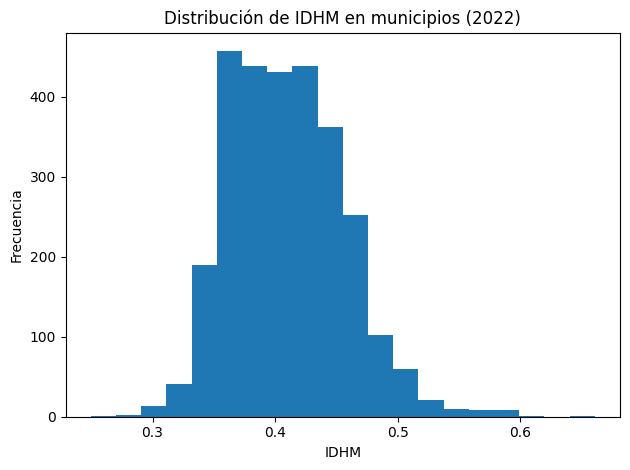

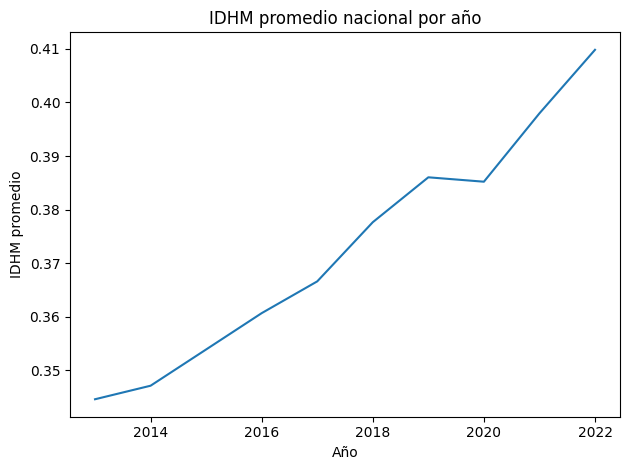

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Cargar dataset final con IDHM
df = pd.read_csv("./IRPFmunicipios_final_IDHM.csv")

# 1) Histograma de IDHM para el año 2022
df_2022 = df[df["year"] == 2022]
plt.figure()
plt.hist(df_2022["IDHM"], bins=20)
plt.title("Distribución de IDHM en municipios (2022)")
plt.xlabel("IDHM")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# 2) Serie temporal del IDHM promedio nacional (2013-2022)
df_mean_year = df.groupby("year")["IDHM"].mean().reset_index()
plt.figure()
plt.plot(df_mean_year["year"], df_mean_year["IDHM"])
plt.title("IDHM promedio nacional por año")
plt.xlabel("Año")
plt.ylabel("IDHM promedio")
plt.tight_layout()
plt.show()



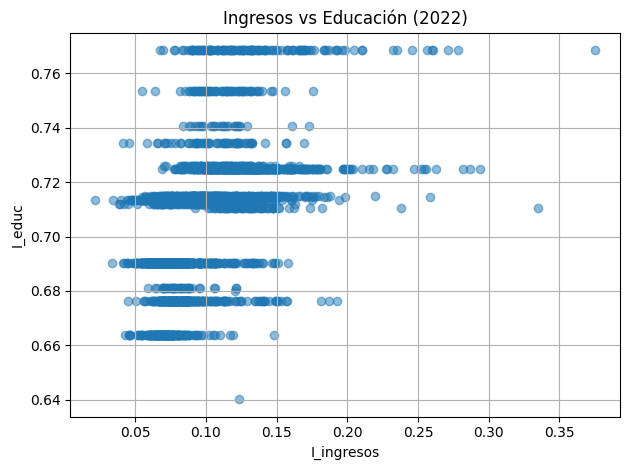

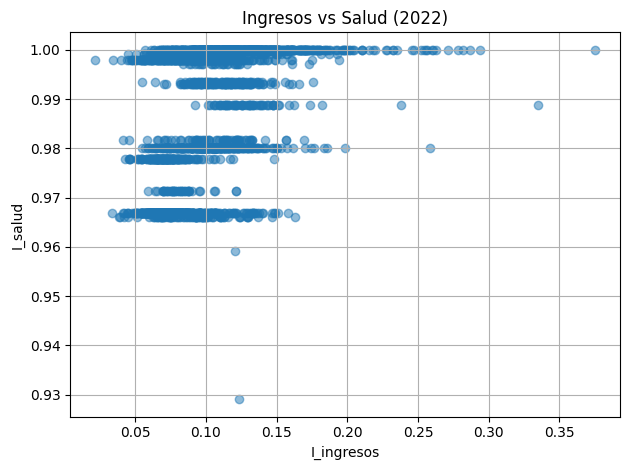

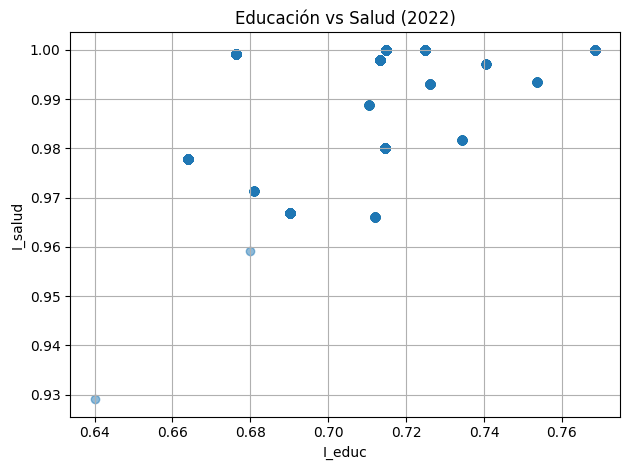

In [ ]:
# Filtrar para el año 2022
df2022 = df[df["year"] == 2022]

# 1) Scatter: I_ingresos vs I_educ
plt.figure()
plt.scatter(df2022["I_ingresos"], df2022["I_educ"], alpha=0.5)
plt.xlabel("I_ingresos")
plt.ylabel("I_educ")
plt.title("Ingresos vs Educación (2022)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Scatter: I_salud vs I_ingresos
plt.figure()
plt.scatter(df2022["I_ingresos"], df2022["I_salud"], alpha=0.5)
plt.xlabel("I_ingresos")
plt.ylabel("I_salud")
plt.title("Ingresos vs Salud (2022)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Scatter: I_salud vs I_educ
plt.figure()
plt.scatter(df2022["I_educ"], df2022["I_salud"], alpha=0.5)
plt.xlabel("I_educ")
plt.ylabel("I_salud")
plt.title("Educación vs Salud (2022)")
plt.grid(True)
plt.tight_layout()
plt.show()



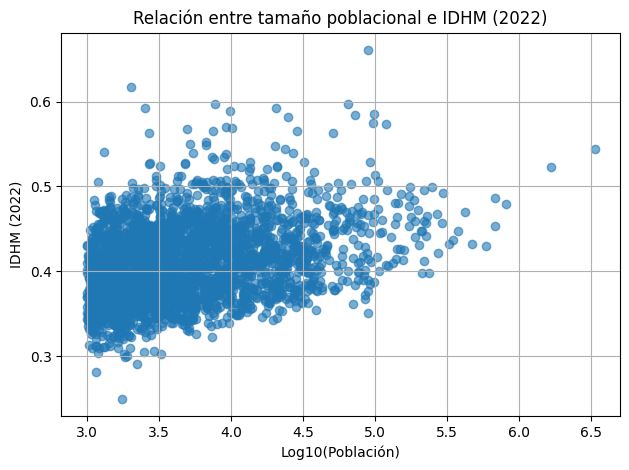

<ipython-input-259-7435c75395f0>:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=ccaas, showfliers=False)


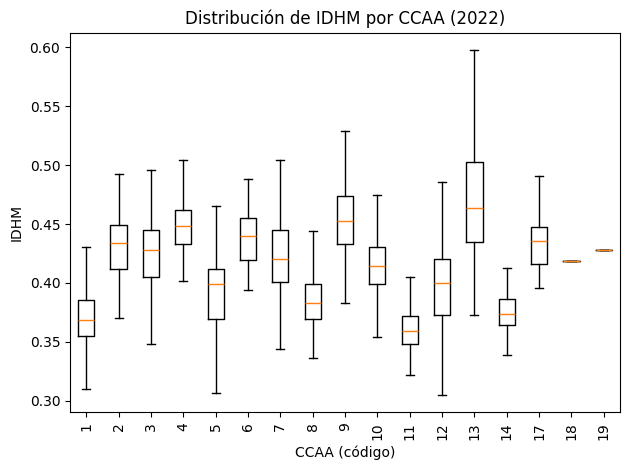

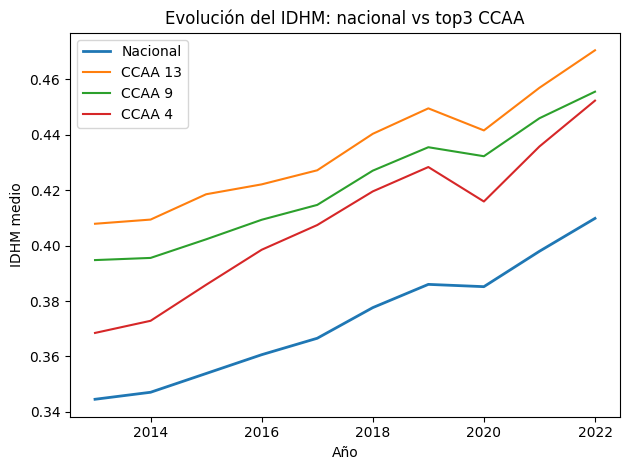

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filtrar para el año 2022
df2022 = df[df["year"] == 2022].copy()

# 1) Scatter: Población vs IDHM (escala log) para 2022
plt.figure()
plt.scatter(np.log10(df2022["population"]), df2022["IDHM"], alpha=0.6)
plt.xlabel("Log10(Población)")
plt.ylabel("IDHM (2022)")
plt.title("Relación entre tamaño poblacional e IDHM (2022)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Boxplot: Distribución de IDHM por CCAA en 2022
plt.figure()
ccaas = sorted(df2022["CODAUTO"].unique())
data = [df2022[df2022["CODAUTO"] == c]["IDHM"] for c in ccaas]
plt.boxplot(data, labels=ccaas, showfliers=False)
plt.xlabel("CCAA (código)")
plt.ylabel("IDHM")
plt.title("Distribución de IDHM por CCAA (2022)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 3) Tendencia: IDHM medio nacional y por CCAA top 3 en evolución (2013-2022)
mean_nacional = df.groupby("year")["IDHM"].mean().reset_index(name="Nacional")
mean_ccaa = df.groupby(["year", "CODAUTO"])["IDHM"].mean().reset_index()

# Identificar top 3 CCAA por IDHM en 2022
top3 = mean_ccaa[mean_ccaa["year"] == 2022].nlargest(3, "IDHM")["CODAUTO"].tolist()

plt.figure()
plt.plot(mean_nacional["year"], mean_nacional["Nacional"], label="Nacional", linewidth=2)
for cc in top3:
    series = mean_ccaa[mean_ccaa["CODAUTO"] == cc]
    plt.plot(series["year"], series["IDHM"], label=f"CCAA {cc}")
plt.xlabel("Año")
plt.ylabel("IDHM medio")
plt.title("Evolución del IDHM: nacional vs top3 CCAA")
plt.legend()
plt.tight_layout()
plt.show()


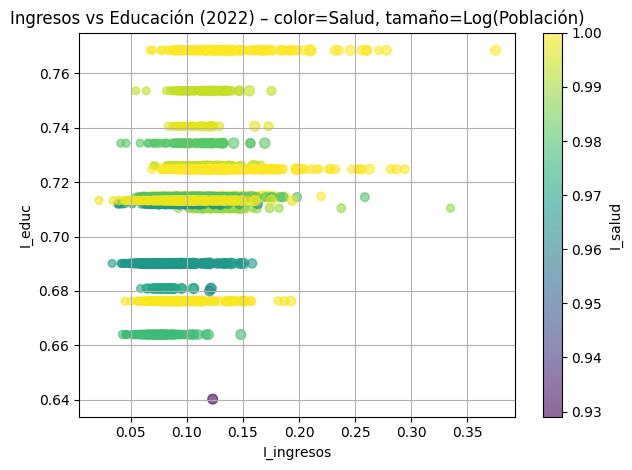

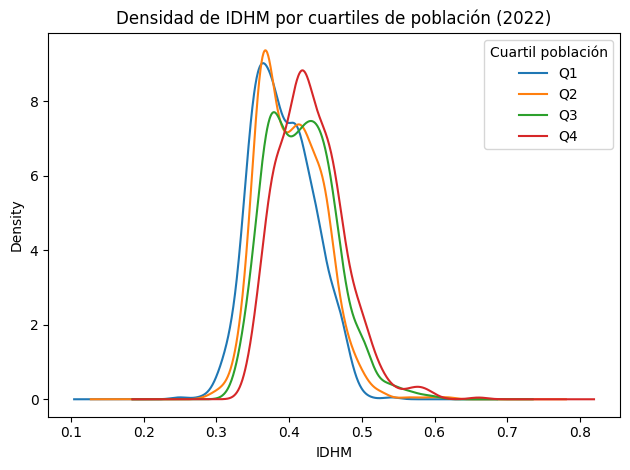

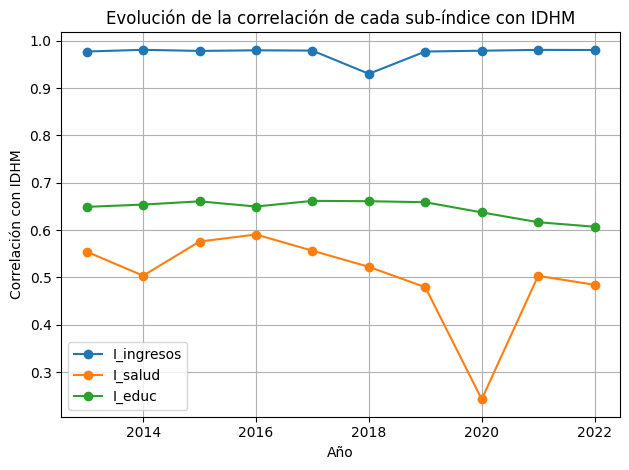

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filtrar para el año 2022
d22 = df[df["year"] == 2022].copy()

# 1) Scatter: I_ingresos vs I_educ, color = I_salud, size = log(population)
plt.figure()
sc = plt.scatter(
    d22["I_ingresos"], d22["I_educ"],
    c=d22["I_salud"], cmap="viridis",
    s=np.log10(d22["population"]+1)*10,
    alpha=0.6
)
plt.colorbar(sc, label="I_salud")
plt.xlabel("I_ingresos")
plt.ylabel("I_educ")
plt.title("Ingresos vs Educación (2022) – color=Salud, tamaño=Log(Población)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) KDE histograms of IDHM by population quartiles
d22["pop_quartile"] = pd.qcut(d22["population"], 4, labels=["Q1","Q2","Q3","Q4"])
plt.figure()
for q in ["Q1","Q2","Q3","Q4"]:
    subset = d22[d22["pop_quartile"] == q]
    subset["IDHM"].plot(kind="kde", label=q)
plt.xlabel("IDHM")
plt.title("Densidad de IDHM por cuartiles de población (2022)")
plt.legend(title="Cuartil población")
plt.tight_layout()
plt.show()

# 3) Correlation evolution: sub-índices vs IDHM año a año
corrs = []
years = sorted(df["year"].unique())
for yr in years:
    subset = df[df["year"] == yr]
    corr = subset[["I_ingresos","I_salud","I_educ","IDHM"]].corr().loc["IDHM", ["I_ingresos","I_salud","I_educ"]]
    corrs.append(corr)

corr_df = pd.DataFrame(corrs, index=years)

plt.figure()
for col in corr_df.columns:
    plt.plot(corr_df.index, corr_df[col], marker='o', label=col)
plt.xlabel("Año")
plt.ylabel("Correlación con IDHM")
plt.title("Evolución de la correlación de cada sub-índice con IDHM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
